In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

from scipy.optimize import minimize, shgo, dual_annealing, differential_evolution
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tickers = ['AAPL', 'WMT', 'JPM', 'PG', 'META', 'V']
benchmark = '^GSPC'

price = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Close'][tickers]
volume = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Volume'][tickers]

benchmark_data = yf.download(benchmark, start='2021-01-01', end='2025-03-12', progress=False)['Close']

start_date = '2021-01-01'
end_date = '2023-12-31'

start_test = '2024-01-01'
end_test = '2025-03-12'
#end_test = datetime.datetime.today().strftime('%Y-%m-%d')

benchmark_train = benchmark_data.loc[start_date:end_date]
benchmark_test = benchmark_data.loc[start_test:end_test]

price_train = price.loc[start_date:end_date]
price_test = price.loc[start_test:end_test]

volume_train = volume.loc[start_date:end_date]
volume_test = volume.loc[start_test:end_test]

rt_train = price_train.pct_change().dropna()
rt_test = price_test.pct_change().dropna()

rt_benchmark_train = benchmark_train.pct_change().dropna()
rt_benchmark_test = benchmark_test.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


# Función graficar pesos

In [3]:
# Gráfica de pesos
def weights_plot(prices, w, fun, fun_description):
    plt.figure(figsize=(6, 4))
    bars = plt.bar(prices.columns, w, width=0.3, color='cadetblue', zorder=3, edgecolor='black', linewidth=0.8)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'%{yval*100:.2f}', 
                ha='center', va='bottom', fontsize=12)

    plt.title(f'{fun_description} = {fun:.6f}', fontsize=16, fontweight='bold')
    plt.ylim(0, 1.15)
    plt.xlabel('Stocks', fontsize=14, fontweight='bold')
    plt.ylabel('Weights', fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
    plt.show()

# Máximo Sharpe

In [4]:
# Pesos óptimos para máximo sharpe
def opt_sharpe(closes, rf):
    rt = closes.pct_change().dropna()
    mean_rt, sigma = rt.mean() * 252, rt.cov() * 252

    sharpe = lambda w, rf, mean_rt, sigma: -(mean_rt.dot(w) - rf) / np.sqrt(w.dot(sigma).dot(w))

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(len(closes.columns))]
    x0 = np.ones(len(closes.columns)) / len(closes.columns)

    resultado = minimize(sharpe, x0, method='SLSQP', args=(rf, mean_rt, sigma), constraints=constraints, bounds=bounds)
    return resultado.x, -resultado.fun

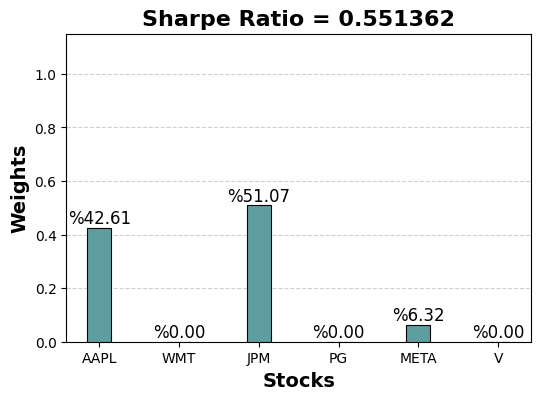

In [5]:
w, sharpe = opt_sharpe(price_train, 0.05)
weights_plot(price_train, w, sharpe, 'Sharpe Ratio')

# LVRR

In [6]:
# Pesos óptimos para LLVR
def opt_lvrr(closes, volume, rf, capital):
    rt = closes.pct_change().dropna()
    mean_rt, sigma = rt.mean() * 252, rt.cov() * 252
    volume_last_90 = volume.iloc[-90:].mean()

    def lvrr(w, rf, mean_rt, sigma, volume_last_90):
        return - ((mean_rt.dot(w) - rf) / np.sqrt(w.dot(sigma).dot(w))) / np.sum(( capital * w / closes.iloc[-1] ) / volume_last_90)

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(len(closes.columns))]
    x0 = np.ones(len(closes.columns)) / len(closes.columns)

    resultado = minimize(lvrr, x0, method='SLSQP', args=(rf, mean_rt, sigma, volume_last_90), constraints=constraints, bounds=bounds)
    return resultado.x, -resultado.fun

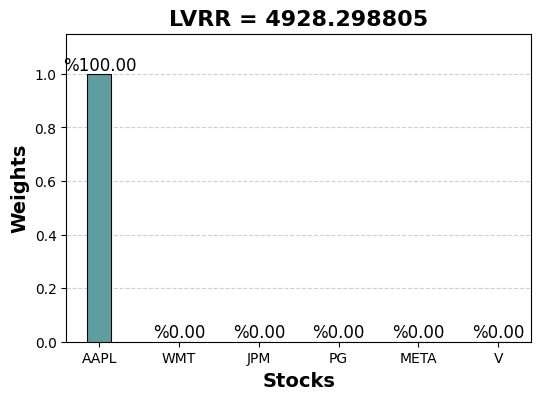

In [7]:
rf = 0.05
pv = 1000000

w, lvrr = opt_lvrr(price_train, volume_train, rf, pv)
weights_plot(price_train, w, lvrr, 'LVRR')

# Omega

In [8]:
# Pesos óptimos para omega
def opt_omega(closes, benchmark):
    rt_closes, rt_benchmark = closes.pct_change().dropna(), benchmark.pct_change().dropna()  
    differences = rt_closes - rt_benchmark.values
    downside = differences.where(differences < 0, 0).std()
    upside = differences.where(differences > 0, 0).std()
    
    omega = lambda w, downside, upside: - (upside / downside).dot(w)

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(len(closes.columns))]
    x0 = np.ones(len(closes.columns)) / len(closes.columns)

    resultado = minimize(omega, x0, method='SLSQP', args=(downside, upside), constraints=constraints, bounds=bounds)
    return resultado.x, -resultado.fun

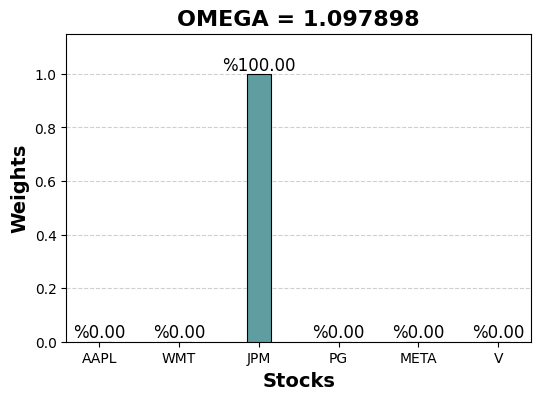

In [9]:
w, omega = opt_omega(price_train, benchmark_train)
weights_plot(price_train, w, omega, 'OMEGA')

# Semivarianza Monte Carlo

In [10]:
def opt_semivarianza_mc(activos, benchmark):
    rt_activos, rt_benchmark = activos.pct_change().dropna(), benchmark.pct_change().dropna()   
    differences = rt_activos - rt_benchmark.values
    downside = differences.where(differences < 0, 0).std()
    corr = rt_activos.corr()

    semivariance = lambda w, downside, corr: ( w.T.dot(np.outer(downside, downside) * corr).dot(w) )

    n = 100000

    pesos = np.random.rand(n, len(activos.columns))
    pesos /= pesos.sum(axis=1)[:, np.newaxis]

    semivariances = np.array([semivariance(w, downside, corr) for w in pesos])
    return pesos[np.argmin(semivariances)], semivariances[np.argmin(semivariances)]

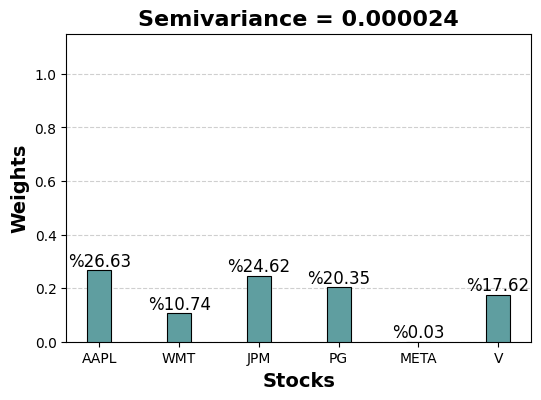

In [11]:
w, semivariance = opt_semivarianza_mc(price_train, benchmark_train)
weights_plot(price_train, w, semivariance, 'Semivariance')

## Semivarianza problema clase

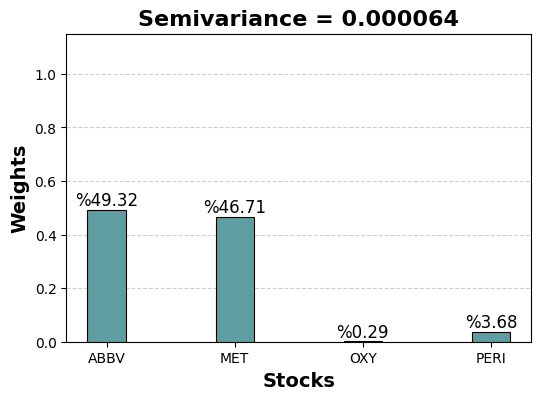

In [12]:
data = pd.read_csv('data_omega_semivarianza.csv').dropna(axis=1)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
activos = data.drop('SPY', axis=1)
benchmark = data[['SPY']]

w, semivariance = opt_semivarianza_mc(activos, benchmark)

weights_plot(activos, w, semivariance, 'Semivariance')

# Semivariance Shgo

In [13]:
def opt_semivarianza_shgo(activos, benchmark):
    rt_activos, rt_benchmark = activos.pct_change().dropna(), benchmark.pct_change().dropna()   
    differences = rt_activos - rt_benchmark.values
    downside = differences.where(differences < 0, 0).std()
    corr = rt_activos.corr()

    semivariance = lambda w, downside, corr: ( w.T.dot(np.outer(downside, downside) * corr).dot(w) )

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(len(activos.columns))]

    resultado = shgo(semivariance, args=(downside, corr), constraints=constraints, bounds=bounds)

    return resultado.x, resultado.fun

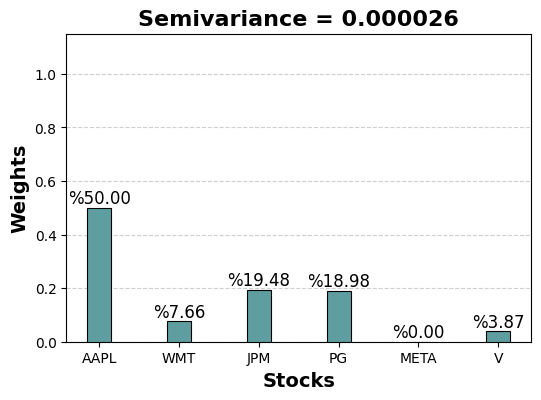

In [14]:
w, semivariance = opt_semivarianza_shgo(price_train, benchmark_train)
weights_plot(price_train, w, semivariance, 'Semivariance')

## Semivarianza Shgo problema en clase

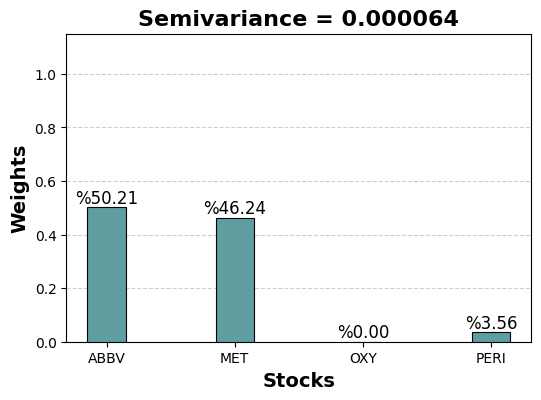

In [15]:
w, semivariance = opt_semivarianza_shgo(activos, benchmark)
weights_plot(activos, w, semivariance, 'Semivariance')